# Audit
Unpaywall's data is fairly unique which makes it hard to verify against another data source to ensure accuracy. 

## Check Unpaywall for the following things:

### Missing data
under 
- is_oa
- published_date 
    - we only have 1 date for published here, CrossRef has a number of different dates for this. 
- oa_status

### look at the Green OA data. 
- It would be interesting to know if the acceptedVersion/submittedVersion distinction is accurate. 
  - submittedVersion seems like it would be a preprint, or some other pre-peer-review version. Therefore less-valuable. However, if a MS has very few changes during peer-review, does the submittedVersion BECOME an acceptedVersion without a change to the label? 

## Issues found in data
- A lot of publication dates seem to be in january. 
  - Checking against CrossRef we see that many of these do have other more nuanced dates associated with them, but this is also an inevitable feature of the data because the publication dates are incomplete in CrossRef. So, where we have an incomplete date: 
    - publication-date is set to 01 of the month, if we have just a year and a month or 
    - if we only have a year, it's set to 01-January.


In [1]:
import json
import gzip
import pandas as pd
import datetime

In [2]:
filepath = r'C:\Users\aday\OneDrive - SAGE Publishing\DATA\Unpaywall\unpaywall_snapshot_2020-10-09T153852.jsonl.gz'

# Look at 01 January records. Are the dates in CrossRef different?
- get a bunch of 01 January records
- get the same articles by DOI from CrossRef
- compare the publication dates

In [3]:
%%time
# get a few january articles. Check the dates against CrossRef
january_recs = list()
with gzip.open(filepath,'rb') as f:
    i = 0
    for line in f:
        try:
            record = json.loads(line)
            pubdate = record.get('published_date',None)
            if pubdate!=None:
                year = pubdate[:4]
                if year>='2015':
                    month = pubdate[5:7]
                    if month=='01':
                        january_recs.append(record)
                        i+=1
                        if i>=100000:
                            break
        except Exception as e:
            print(record)
            print(e)
            break
            
january_recs = {rec['doi']: rec for rec in january_recs if 'doi' in rec}
len(january_recs)

Wall time: 34.3 s


100000

In [4]:
dois = list(january_recs)
len(dois)

100000

In [5]:
from tools.CrossRefUtils import CrossRefUtils
from tools.CrossRefEarliestDate import CrossRefEarliestDate

In [6]:
# conveniently, I have a CrossRef snapshot mounted locally
# if you don't have one, there is a utility to download from the CrossRef API
import pymongo
client = pymongo.MongoClient()
db = client['crossref']
coll = db['works']

In [12]:
# when were the january articles published?
import os
from tqdm import tqdm
date_data_path = 'data/date_data.csv'
if os.path.exists(date_data_path):
    dates = pd.read_csv(date_data_path)
    dates['cr_date'] = pd.to_datetime(dates['cr_date'])
    dates['up_date'] = pd.to_datetime(dates['up_date'])
else:
    print(datetime.datetime.now(), 'Searching CrossRef Database')
    cr_data = list()
    for doi in tqdm(dois):
        try:
            # hit the CrossRef snapshot
            rec = coll.find_one({'DOI':doi})
            rec.pop('_id')
            cr_data.append(rec)
        except:
            pass
    cr_dct = {record['DOI']: record for record in cr_data}
    print(datetime.datetime.now(), len(cr_dct), 'items found from CrossRef on MongoDB')
    
    # If you don't have a CrossRef snapshot, you can use this.
#     remaining_dois = [doi for doi in dois if doi not in cr_dct]
#     cr_data = list(CrossRefUtils().get_many_crossref(remaining_dois, retry_failures=True))
#     for record in cr_data:
#         cr_dct[record['DOI']]= record
    
#     print(datetime.datetime.now(), len(cr_dct), 'items found from CrossRef API')

    cr_earliest_dates = []
    unpaywall_dates = []
    dois_out = []
    for doi in dois:
        if doi in january_recs and doi in cr_dct:
            dois_out.append(doi)
            cr_record = cr_dct[doi]
            cr_earliest_date_dct = CrossRefEarliestDate(cr_record).earliest_date
            cr_earliest_datetime_str = cr_earliest_date_dct['date-time']
#             cr_earliest_datetime = datetime.datetime.strptime(cr_earliest_datetime_str,'%Y-%m-%d')
            cr_earliest_dates.append(cr_earliest_datetime_str)
            up_record = january_recs[doi]
            up_date = up_record['published_date']
#             up_datetime = datetime.datetime.strptime(up_date)#, format='%Y-%m-%d')
            unpaywall_dates.append(up_date)
    dates = pd.DataFrame({'doi':dois_out,'cr_date':cr_earliest_dates,'up_date':unpaywall_dates})
    print(datetime.datetime.now(), 'Writing out dataframe:{}'.format(dates.shape))
    dates.to_csv(date_data_path)


  0%|▏                                                                          | 176/100000 [00:00<00:57, 1742.60it/s]

2021-02-17 11:20:35.128730 Searching CrossRef Database


100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [01:01<00:00, 1613.09it/s]


2021-02-17 11:21:38.271444 90164 items found from CrossRef on MongoDB
2021-02-17 11:22:03.155305 Writing out dataframe:(90164, 3)


In [13]:
dates.sample(4)

,doi,cr_date,up_date
22202,10.1145/2899475.2899480,2016-01-01T00:00:00Z,2016-01-01
53089,10.22360/springsim.2018.cns.006,2017-01-01T00:00:00Z,2017-01-01
84197,10.32737/2221-8688-2018-1-136-144,2018-01-01T00:00:00Z,2018-01-01
31280,10.1055/b-0039-168647,2019-01-01T00:00:00Z,2019-01-01


In [21]:
dates['cr_date'] = pd.to_datetime(dates['cr_date'],utc=True) #  format="%Y-%m-%d")
dates['up_date'] = pd.to_datetime(dates['up_date'],utc=True)

In [22]:
dates.sample(4)

,doi,cr_date,up_date
24663,10.2991/emcs-16.2016.160,2016-01-01 00:00:00+00:00,2016-01-01 00:00:00+00:00
464,10.25206/2310-9793-2017-5-4-239-244,2017-01-01 00:00:00+00:00,2017-01-01 00:00:00+00:00
61792,10.1097/01.nep.0000000000000433,2018-12-31 00:00:00+00:00,2019-01-01 00:00:00+00:00
41,10.1177/1178221820928427,2020-01-01 00:00:00+00:00,2020-01-01 00:00:00+00:00


In [23]:
dates['delta'] = dates['cr_date'] - dates['up_date']

In [25]:
dates.sample()

,doi,cr_date,up_date,delta
8010,10.21527/2179-1309.2020.110.123-141,2020-01-02 00:00:00+00:00,2020-01-02 00:00:00+00:00,0 days


In [39]:
import numpy as np

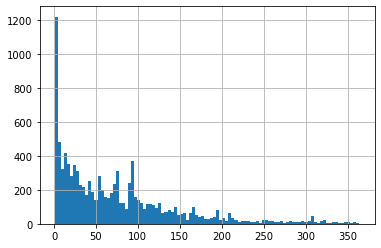

In [47]:
pd.Series(np.sqrt(x.days**2) for x in dates['delta'].tolist() if x.days**2<(365**2) and x.days**2>=1).hist(bins = 100)